In [1]:
from dynamita.sumon import dur, Sumo
import numpy as np
import pandas as pd
import time
import os
import shutil
import matplotlib.pyplot as plt
import xlrd
# from cyEKF import MLEEKF

In [2]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from copy import deepcopy
class MLEEKF(EKF):
    def __init__(self,M):
        EKF.__init__(self,4,1,7)
        self.dt = 1/144
        self.V = 2000 # initialize constant parameters 
        self.KNH = 0.5
        self.KO1 = 0.6
        self.KO2 = 0.4
        self.KO3 = 0.2 
        self.fr = 0.7 
        self.M = M
    
    ## using the symbolic results above to define state prediction function f(x,u)
    def fxu(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        x_next = np.array([[SNH1 + dt*(QPE*TKN*fr/V + SNH1*(-QMLE - QPE - QRAS)/V + SNH3*(QMLE + QRAS)/V + SO1*r/(KO1 + SO1))], 
                           [SNH2 + dt*(SNH1*(QMLE + QPE + QRAS)/V + SNH2*SO2*r/((KNH + SNH2)*(KO2 + SO2)) + SNH2*(-QMLE - QPE - QRAS)/V)],
                           [SNH3 + dt*(SNH2*(QMLE + QPE + QRAS)/V + SNH3*SO3*r/((KNH + SNH3)*(KO3 + SO3)) + SNH3*(-QMLE - QPE - QRAS)/V)], 
                           [r]])
        return x_next
        
    ## using the symbolic results above to define jacobian of the state transition function over state,dfdx  
    def F_j(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        # dFdx should be a 4 by 4 matrix 
        dFdx = np.array([[1 + dt*(-QMLE - QPE - QRAS)/V, 0, dt*(QMLE + QRAS)/V, SO1*dt/(KO1 + SO1)], 
                         [dt*(QMLE + QPE + QRAS)/V, dt*(-SNH2*SO2*r/((KNH + SNH2)**2*(KO2 + SO2)) + SO2*r/((KNH + SNH2)*(KO2 + SO2)) + (-QMLE - QPE - QRAS)/V) + 1, 0, SNH2*SO2*dt/((KNH + SNH2)*(KO2 + SO2))], 
                         [0, dt*(QMLE + QPE + QRAS)/V, dt*(-SNH3*SO3*r/((KNH + SNH3)**2*(KO3 + SO3)) + SO3*r/((KNH + SNH3)*(KO3 + SO3)) + (-QMLE - QPE - QRAS)/V) + 1, SNH3*SO3*dt/((KNH + SNH3)*(KO3 + SO3))],
                         [0, 0, 0, 1]])
        return dFdx
   
    ## using the symbolic results above to define jacobian of the state transition function over input,dfdu
    def V_j(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        # dFdx should be a 4 by 7 matrix 
        dFdu = np.array([[dt*(-SNH1/V + TKN*fr/V), dt*(-SNH1/V + SNH3/V), dt*(-SNH1/V + SNH3/V), QPE*dt*fr/V, dt*(-SO1*r/(KO1 + SO1)**2 + r/(KO1 + SO1)), 0, 0],
                         [dt*(SNH1/V - SNH2/V), dt*(SNH1/V - SNH2/V), dt*(SNH1/V - SNH2/V), 0, 0, dt*(-SNH2*SO2*r/((KNH + SNH2)*(KO2 + SO2)**2) + SNH2*r/((KNH + SNH2)*(KO2 + SO2))), 0], 
                         [dt*(SNH2/V - SNH3/V), dt*(SNH2/V - SNH3/V), dt*(SNH2/V - SNH3/V), 0, 0, 0, dt*(-SNH3*SO3*r/((KNH + SNH3)*(KO3 + SO3)**2) + SNH3*r/((KNH + SNH3)*(KO3 + SO3)))],
                         [0, 0, 0, 0, 0, 0, 0]])
        return dFdu
    
    def predict(self,u):
        # Project the state ahead
        self.x = self.fxu(self.x,u)
        # Project the error covariance ahead 
        F = self.F_j(self.x,u).astype(float)
        V = self.V_j(self.x,u).astype(float)
        # covariance of motion noise in control space -std of QPE QMLE QRAS QTKN SO1 SO2 SO3
        M = self.M
        self.P = F @ self.P @ F.T + V @ M @ V.T 
        self.P.astype(float)
        
    def HJacobian(self,x):
        return np.array([[0,0,1,0]]) 


    def hx(self,x):
        return x[2]

    def residual(self,a,b):
        return a-b

    def ekf_update(self,z):
        self.update(np.array([z]),HJacobian=self.HJacobian,Hx = self.hx, residual=self.residual )

# Step 1: Create the the Extended Kalman Filter object

In [3]:
# Define the input covaraince matrix 
# Inputs are : QPE, QRAS, QMLE, TKN, SO1, SO2, SO3
in_cov = np.eye(7)
ekf = MLEEKF(in_cov)

# Set the first guess of for the estimated state: SNH1, SNH2, SNH3, r 
# For accuary, I suggest started this fromt 
ekf.x = np.array([6,3,1,-330])

# Set the first guess for the state covariance matrix 
ekf.P = np.diag([1,1,1,20])

# ---------------EKF tuning parameters ----------------------------
# The ratio between Q/R control the speed of convergence 
ekf.R = 0.1   # Measurement noise covariance matrix 
ekf.Q = np.eye(1)         # Process noise covariance matrix 

# Step 2: Set up the SUMO-python Interface

In [4]:
sumoPath = "c:/Users/28417/AppData//Local/Dynamita/Sumo20"
licenseFile = "c:/Users/28417/AppData/Roaming/Dynamita/Sumo20/networklicense.sumolic"
model = "C:/Users/28417/Desktop/MIMO_control_design_for_MLE/Openloop.sumo"
initial_file = "C:/Users/28417/Desktop/MIMO_control_design_for_MLE/script_Initialize.scs"

# Check the sumo license 
sumo = Sumo(sumoPath, licenseFile) 

# Add message_callback so that we can see if commands in python are successfully sent to SUMO 
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0
sumo.add_message_callback(message_callback)


License OK...


In [5]:
# Load the sumo model 
if sumo.model_loaded:
    sumo.unload_model()
sumo.load_model(model)   # 0 means successfully loaded 

# Load initial files 
initial_command = ' execute ' + initial_file + ';'
sumo.send_command('reset')
sumo.send_command(initial_command)

Trying to load model: b'C:\\Users\\28417\\AppData\\Local\\Temp\\tmpmwr72do6\\sumoproject.dll'


# Define the input functions 

In [6]:
def QPE_fun(t,mean=24000,std=500):
    true_value = mean
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]
    return true_value,noisy_value

def QRAS_fun(t,mean=24000,std=500):
    true_value = mean
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]
    return true_value,noisy_value

def QMLE_fun(t,mean=36000,std=500):
    true_value = mean
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]
    return true_value,noisy_value

def TKN_fun(t,mean=56.6,std=3):
    true_value = mean
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]
    return true_value,noisy_value

def SO1_fun(t,mean=1.5, std=0.1):
    true_value = mean
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]
    return true_value,noisy_value

def SO2_fun(t,mean=1,std=0.1):
    true_value = mean 
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]     
    return true_value,noisy_value

def SO3_fun(t,mean=0.5,std=0.1):
    true_value = mean 
    noisy_value = true_value + std*np.random.randn(1).astype(float)[0]     
    return true_value,noisy_value

def temp_fun(t,base_temp=20):
    true_value = base_temp - 5/(1+np.exp(-3*(t-5)))
    return true_value

In [7]:
sim_run_time =30 


Text(0, 0.5, 'Temp, mg/L')

530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\28417\AppData\Local\Dynamita\Sumo20\.tmp\1zmcvkck.uxg\sumoproject.xml
530049 Core loop started.
530011 Reset
530036 Script file C:/Users/28417/Desktop/MIMO_control_design_for_MLE/script_Initialize.scs loaded.
530007 Path set to: "C:/Users/28417/Desktop/MIMO_control_design_for_MLE".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 0.5
530021 Set: Sumo__Plant__CSTR2__param__Sumo1__KNHx_NITO_AS to 0.5
530021 Set: Sumo__Plant__CSTR3__param__Sumo1__KNHx_NITO_AS to 0.5
530021 Set: Sumo__Plant__CSTR4__param__Sumo1__KNHx_NITO_AS to 0.5
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__Sideflowdivider1__param__Qpumped_target to 600
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__CSTR1__param__L_Vtrain to 2000
530021 Set: Sumo__Plant__CSTR1__param__SO2 to 0
530021 Set: Sumo__Plant__CSTR2__param__L_Vtrain to

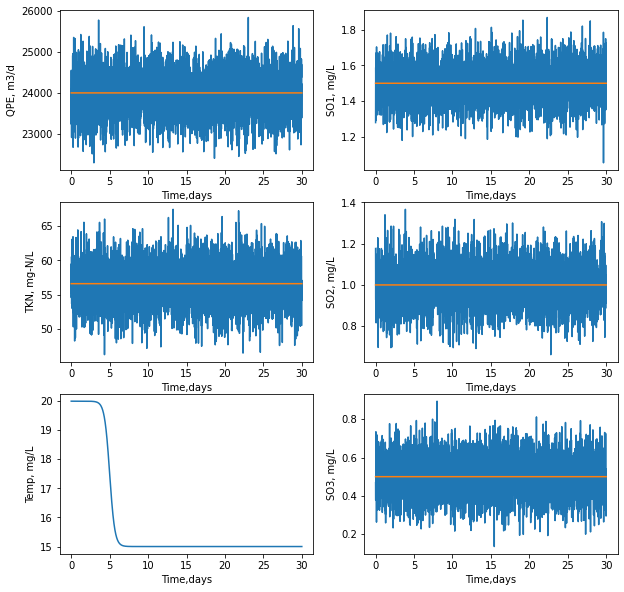

In [8]:
t_vec = np.arange(0,sim_run_time,1/144)
fig = plt.figure(figsize=(10,10))
# QPE 
ax = fig.add_subplot(321)

out1_list = np.zeros(t_vec.shape)
out2_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1,out2 = QPE_fun(t)
    out1_list[i] =  out1
    out2_list[i] =  out2
ax.plot(t_vec,out2_list)
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("QPE, m3/d")

# TKN
ax = fig.add_subplot(323)

out1_list = np.zeros(t_vec.shape)
out2_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1,out2 = TKN_fun(t)
    out1_list[i] =  out1
    out2_list[i] =  out2
ax.plot(t_vec,out2_list)
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("TKN, mg-N/L")

# SO1
ax = fig.add_subplot(322)

out1_list = np.zeros(t_vec.shape)
out2_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1,out2 = SO1_fun(t)
    out1_list[i] =  out1
    out2_list[i] =  out2
ax.plot(t_vec,out2_list)
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("SO1, mg/L")

# SO2
ax = fig.add_subplot(324)

out1_list = np.zeros(t_vec.shape)
out2_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1,out2 = SO2_fun(t)
    out1_list[i] =  out1
    out2_list[i] =  out2
ax.plot(t_vec,out2_list)
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("SO2, mg/L")

# SO3
ax = fig.add_subplot(326)

out1_list = np.zeros(t_vec.shape)
out2_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1,out2 = SO3_fun(t)
    out1_list[i] =  out1
    out2_list[i] =  out2
ax.plot(t_vec,out2_list)
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("SO3, mg/L")

# Temp
ax = fig.add_subplot(325)

out1_list = np.zeros(t_vec.shape)

for i,t in enumerate(t_vec):
    out1 = temp_fun(t)
    out1_list[i] =  out1
    
ax.plot(t_vec,out1_list)
ax.set_xlabel("Time,days")
ax.set_ylabel("Temp, mg/L")

# Step 4: Define SUMO-python communication

I'd like SUMO to sample signals every 1 minute and the observer updates every 10 minutes

In [9]:
# Simulation time setting for SUMO 
stop_days = sim_run_time
sumo.set_stopTime(stop_days*dur.day)

# Set commnunication frequency between SUMO and python 
comm_freq = 1 # in minutes
sumo.data_communicate_interval = comm_freq*dur.min # every minute

obser_freq = 10 # in minutes

In [10]:
def datacomm_callback(sumo):
    global true_pd
    global noise_pd
    global ekf
    global temp_pd
    # For every miniutes,update the input of the flow 
    # Input QPE
    QPE, QPE_n = QPE_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__Influent1__param__Q ' + str(QPE) + ';'
    sumo.send_command(command)
    
    # Input QRAS
    QRAS, QRAS_n = QRAS_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__Clarifier1__param__Qsludge_target ' + str(QRAS) + ';'
    sumo.send_command(command)
    
    # Input QMLE
    QMLE, QMLE_n = QMLE_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target ' + str(QMLE) + ';'
    sumo.send_command(command)
    
    # Input TKN
    TKN, TKN_n = TKN_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__Influent1__param__TKN ' + str(TKN) + ';'
    sumo.send_command(command)
    
    # Input SO1
    SO1, SO1_n = SO1_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__CSTR2__param__SO2 ' + str(SO1) + ';'
    sumo.send_command(command)
    
    # Input SO2
    SO2, SO2_n = SO2_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__CSTR3__param__SO2 ' + str(SO2) + ';'
    sumo.send_command(command)
    
    # Input SO3
    SO3, SO3_n = SO3_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__CSTR4__param__SO2 ' + str(SO3) + ';'
    sumo.send_command(command)
    
    # Input Temp
    temp = temp_fun(sumo.time_ms()/dur.day)
    command = 'set Sumo__Plant__Influent1__param__T ' + str(temp) + ';'
    sumo.send_command(command)
    
   
    # Extract effluent ammonia information
    SNH1 = sumo.SV(b'Sumo__Plant__CSTR2__SNHx')
    SNH1_n = SNH1 + SNH1*0.1*np.random.randn(1).astype(float)[0]
    
    SNH2 = sumo.SV(b'Sumo__Plant__CSTR3__SNHx')
    SNH2_n = SNH2 + 0.3*np.random.randn(1).astype(float)[0]
    
    SNH3 = sumo.SV(b'Sumo__Plant__CSTR4__SNHx')
    SNH3_n = SNH3 + 0.1*np.random.randn(1).astype(float)[0]
       
    # Store all data in the the dataframe 
    t= np.array([sumo.time_ms()/dur.day])
    
    u = np.array([QPE,QRAS,QMLE,TKN,SO1,SO2,SO3])
    u_n = np.array([QPE_n,QRAS_n,QMLE_n,TKN_n,SO1_n,SO2_n,SO3_n])
    
    x = np.array([SNH1,SNH2,SNH3])
    x_n= np.array([SNH1_n,SNH2_n,SNH3_n])
    
    temp = np.array([temp])
    
    true_pd.loc[len(true_pd)] = np.concatenate((t,u,x),axis = 0)
    noise_pd.loc[len(noise_pd)] = np.concatenate((t,u_n,x_n),axis = 0)
    temp_pd.loc[len(temp_pd)] = np.concatenate((t,temp),axis = 0)
    
    ekf.predict(u_n)
    
    z = np.array([x_n[2]])
    ekf.ekf_update(z)
    EKF_estiamte.loc[len(EKF_estiamte)] = np.concatenate((t,ekf.x.reshape(-1)),axis = 0)
    if sumo.time_ms()%dur.day==0:
        print(sumo.time_days(), "days\t")
    return 0

# Register the datacomm_callback
sumo.add_datacomm_callback(datacomm_callback)

530021 Set: Sumo__StopTime to 2592000000


In [11]:
global true_pd
global noise_pd
global EKF_estiamte
global temp_pd
true_pd = pd.DataFrame(columns=['Time','QPE','QRAS','QMLE','TKN','SO1','SO2','SO3','SNH1','SNH2','SNH3'])
noise_pd = true_pd.copy()
EKF_estiamte =pd.DataFrame(columns=['Time','SNH1','SNH2','SNH3','r'])
temp_pd =pd.DataFrame(columns=['Time','Temp'])

global ekf
in_cov = np.diag([500,500,500,3,0.1,0.1,0.1])
ekf = MLEEKF(in_cov)
ekf.x = np.array([5,1.5,0.4,-325])
ekf.P = np.diag([5, 5, 5, 10])
# ekf.Q = np.diag([1, 1, 1, 10])
ekf.R = 0.01



In [12]:
sumo.run_model()
while not sumo.simulation_finished:
    time.sleep(0.01)

530002 Simulation started.
0.0 days	
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 20
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 20
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
53002

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 20
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 20
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.9993
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.9992
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.982
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.9796
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifie

4.0 days	
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.7629
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 19.733
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 18.1123
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 17.9633
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.7402
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.6648
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0549
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0485
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0058
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0052
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0004
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15.0003
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifi

530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T t

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
10.0 days	
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarif

530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO

16.0 days	
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarif

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

28.0 days	
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarif

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param__Qsludge_target to 24000
530021 Set: Sumo__Plant__Sideflowdivider1_1__param__Qpumped_target to 36000
530021 Set: Sumo__Plant__Influent1__param__TKN to 56.6
530021 Set: Sumo__Plant__CSTR2__param__SO2 to 1.5
530021 Set: Sumo__Plant__CSTR3__param__SO2 to 1
530021 Set: Sumo__Plant__CSTR4__param__SO2 to 0.5
530021 Set: Sumo__Plant__Influent1__param__T to 15
530021 Set: Sumo__Plant__Influent1__param__Q to 24000
530021 Set: Sumo__Plant__Clarifier1__param

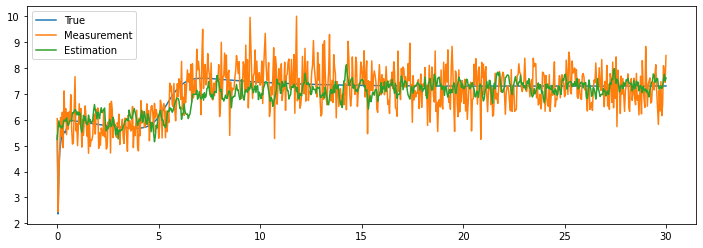

In [13]:
plt.figure(figsize=(12,4))
plt.plot(true_pd.Time,true_pd.SNH1)
plt.plot(noise_pd.Time,noise_pd.SNH1)
plt.plot(EKF_estiamte.Time,EKF_estiamte.SNH1)
plt.legend(['True','Measurement','Estimation'])

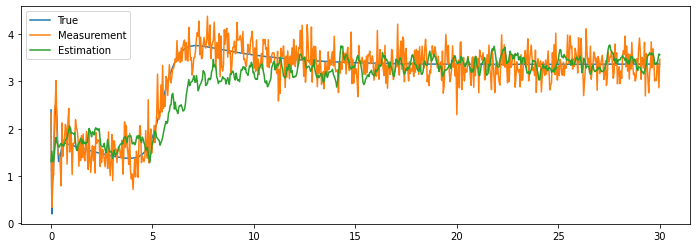

In [14]:
plt.figure(figsize=(12,4))
plt.plot(true_pd.Time,true_pd.SNH2)
plt.plot(noise_pd.Time,noise_pd.SNH2)
plt.plot(EKF_estiamte.Time,EKF_estiamte.SNH2)
plt.legend(['True','Measurement','Estimation'])

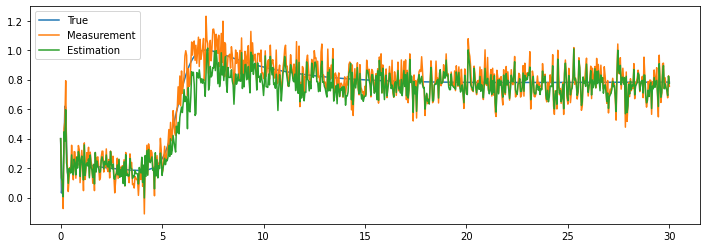

In [15]:
plt.figure(figsize=(12,4))
plt.plot(true_pd.Time,true_pd.SNH3)
plt.plot(noise_pd.Time,noise_pd.SNH3)
plt.plot(EKF_estiamte.Time,EKF_estiamte.SNH3)
plt.legend(['True','Measurement','Estimation'])

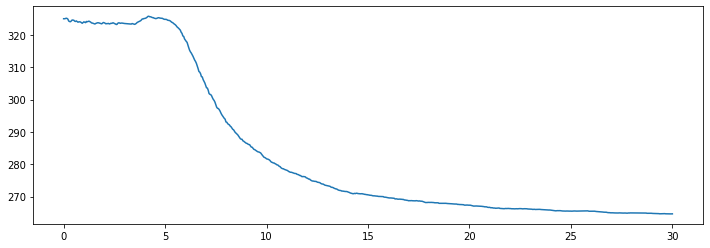

In [16]:
plt.figure(figsize=(12,4))
plt.plot(EKF_estiamte.Time,-EKF_estiamte.r)

In [1]:
#with pd.ExcelWriter('C:/Users/28417/Desktop/Greybox Wrapup/Tables.xlsx',
#                    mode='a') as writer:  
#    EKF_estiamte.to_excel(writer, sheet_name='EKF_estimate_temp')
#    true_pd.to_excel(writer, sheet_name='true_pd_temp')
#    noise_pd.to_excel(writer, sheet_name='noise_pd_temp')
#    temp_pd.to_excel(writer, sheet_name='temp_pd')